Nathan Deinlein <br>
Ryan Kinney <br>
Chris Roche <br>
Cameron Stewart <br>

# Machine Learning 1 - MiniLab LR and SVM

## Section 1: Create Models

### Logistic Regression

Logistic Regression is a statistical technique for categorizing a binary outcome. For the horse racing data set, we're using predictors such as horse age, rating, and odds to predict whether a horse will win or lose a race.
We began our logistic regression model implementation by importing the necessary libraries and then reading in the data. In Lab 1, once our data was cleaned we saved off a csv file titled "runs_clean.csv" to our GitHub repository. For this lab we read in that file as a starting point since it is already cleaned, all missing data is imputed, and features are formatted appropriately.


In [1]:
# Load libraries
import pandas as pd
import numpy as np
import matplotlib
import matplotlib.pyplot as plt
%matplotlib inline
from sklearn.model_selection import train_test_split
from sklearn import metrics as mt
from sklearn.metrics import plot_confusion_matrix, roc_auc_score
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import ConfusionMatrixDisplay
from sklearn.svm import SVC
import warnings
warnings.simplefilter('ignore', DeprecationWarning)

In [2]:
## Read in the cleaned dataframe from Lab 1
url = "https://raw.githubusercontent.com/nedeinlein/Machine_Learning_I/main/runs_clean.csv"
runs_df = pd.read_csv(url, index_col=False)

Logistic regression requires all variables to be numeric. Using the info function we can inspect the data set for objects and determine how to use or not use them.

In [3]:
# Summary statistics of each feature
runs_df.info()
runs_df.head()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 79423 entries, 0 to 79422
Data columns (total 29 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   Unnamed: 0       79423 non-null  int64  
 1   race_id          79423 non-null  int64  
 2   horse_no         79423 non-null  int64  
 3   horse_id         79423 non-null  int64  
 4   result           79423 non-null  int64  
 5   won              79423 non-null  float64
 6   lengths_behind   79423 non-null  float64
 7   horse_age        79423 non-null  int64  
 8   horse_country    79423 non-null  object 
 9   horse_type       79423 non-null  object 
 10  horse_rating     79423 non-null  int64  
 11  horse_gear       79423 non-null  object 
 12  declared_weight  79423 non-null  float64
 13  actual_weight    79423 non-null  int64  
 14  draw             79423 non-null  int64  
 15  position_sec1    79423 non-null  int64  
 16  position_sec2    79423 non-null  int64  
 17  position_sec

,Unnamed: 0,race_id,horse_no,horse_id,result,won,lengths_behind,horse_age,horse_country,horse_type,...,behind_sec2,behind_sec3,time1,time2,time3,finish_time,win_odds,place_odds,trainer_id,jockey_id
0,0,0,1,3917,10,0.0,8.00,3,AUS,Gelding,...,2.00,1.50,13.85,21.59,23.86,83.92,9.7,3.7,118,2
1,1,0,2,2157,8,0.0,5.75,3,NZ,Gelding,...,9.00,5.00,14.57,21.99,23.30,83.56,16.0,4.9,164,57
2,2,0,3,858,7,0.0,4.75,3,NZ,Gelding,...,1.00,0.75,13.69,21.59,23.90,83.40,3.5,1.5,137,18
3,3,0,4,1853,9,0.0,6.25,3,SAF,Gelding,...,5.00,3.50,14.09,21.83,23.70,83.62,39.0,11.0,80,59
4,4,0,5,2796,6,0.0,3.75,3,GB,Gelding,...,8.75,4.25,14.77,21.75,23.22,83.24,50.0,14.0,9,154


#### One Hot Encoding

Horse Country and Horse Type are both of type object. These are strings that represent where a horse is from or what type it is (e.g. gelding, mare). For both of these, we used one-hot encoding. This allows us to numerically represent them and therefore keep them in the logistic regression model.

First we'll check how many unique types there are in the two variables.

In [4]:
# How many unique values are in horse_type and horse_country
n = runs_df['horse_type'].nunique()
print("Number of horse types: ", n)

n = runs_df['horse_country'].nunique()
print("Number of horse countries: ", n)

Number of horse types:  9
Number of horse countries:  16


Now we will perform the one hot encoding. Note, this will greatly increase the number of columns in our data set since we're now making boolean entries for each of the nine horse types and sixteen countries found in the data set. Therefore, we'll add the new columns to a second data set so that we can easily choose whether or not to include the new features in the future.

In [5]:
# Use one hot encoding on non-numerical features
## (Then remove them from the drop code chunk below)
# perform one-hot encoding of the categorical data "embarked"
tmp_df = pd.get_dummies(runs_df.horse_country,prefix='horse_country')
runs_df_onehot = pd.concat((runs_df,tmp_df),axis=1) # add back into the dataframe

tmp_df = pd.get_dummies(runs_df.horse_type,prefix='horse_type')
runs_df_onehot = pd.concat((runs_df_onehot,tmp_df),axis=1) # add back into the dataframe

In addition to the one-hot encoding, we want to add another new feature to the set, this new feature is something we'll try to predict. There are two common types of bets in horse racing: to win and to show. Win is for a horse to finish first and show is for a horse to finish top three. Using the result feature (a horse's finish position from 1 - 14) we can create a new feature for a result of 1, 2, or 3.

#### Create new Show feature to predict

In [6]:
# Add a Show result feature
runs_df['show'] = np.where(runs_df['result'] <= 3, 1, 0)
runs_df_onehot['show'] = np.where(runs_df['result'] <= 3, 1, 0)

runs_df.head(10)

,Unnamed: 0,race_id,horse_no,horse_id,result,won,lengths_behind,horse_age,horse_country,horse_type,...,behind_sec3,time1,time2,time3,finish_time,win_odds,place_odds,trainer_id,jockey_id,show
0,0,0,1,3917,10,0.0,8.00,3,AUS,Gelding,...,1.50,13.85,21.59,23.86,83.92,9.7,3.7,118,2,0
1,1,0,2,2157,8,0.0,5.75,3,NZ,Gelding,...,5.00,14.57,21.99,23.30,83.56,16.0,4.9,164,57,0
2,2,0,3,858,7,0.0,4.75,3,NZ,Gelding,...,0.75,13.69,21.59,23.90,83.40,3.5,1.5,137,18,0
3,3,0,4,1853,9,0.0,6.25,3,SAF,Gelding,...,3.50,14.09,21.83,23.70,83.62,39.0,11.0,80,59,0
4,4,0,5,2796,6,0.0,3.75,3,GB,Gelding,...,4.25,14.77,21.75,23.22,83.24,50.0,14.0,9,154,0
5,5,0,6,3296,3,0.0,1.25,3,NZ,Gelding,...,1.25,14.33,22.03,22.90,82.83,7.0,1.8,54,34,1
6,6,0,7,911,12,0.0,9.50,3,NZ,Gelding,...,0.75,13.53,21.59,23.94,84.15,99.0,28.0,55,149,0
7,7,0,8,2170,1,1.0,0.00,3,AUS,Gelding,...,3.25,14.13,21.87,23.58,82.64,12.0,3.6,47,183,1
8,8,0,9,1730,13,0.0,9.75,3,NZ,Gelding,...,1.25,13.65,21.71,23.90,84.20,38.0,13.0,75,131,0
9,9,0,10,2998,14,0.0,999.00,3,AUS,Mare,...,16.75,15.05,22.31,24.38,92.20,39.0,12.0,109,145,0


Now that we have all the necessary features and the data set is cleaned, we will divide into test and train data sets. We used an 80/20 split: 80% of the data will be used to train the models and the remaining 20% will be used to generate a confusion matrix so that we can evaluate performance and compare various models.

Since the data set contains features not known pre-race (e.g. how many lengths the horse finished behind the winner, lap times, etc.) we will drop those from the training and test sets.

#### Test and Train set split

A total of three test/train data sets were created. One for runs_data without one hot encoding, one for runs_data with one-hot encoding, and one with one-hot encoding but the target is "show" instead of "win". All are derived from the same data set with the same random seed value.

In [7]:
# Split the data and target
# Only use features known pre-race (e.g. not finish time)
# Remove non-numerical features (e.g. horse country) since we performed one hot encoding
runs_data = runs_df.drop(['Unnamed: 0','race_id','horse_id','result','won','show','lengths_behind','horse_country','horse_type','horse_gear','position_sec1','position_sec2','position_sec3','behind_sec1','behind_sec2','behind_sec3','time1','time2','time3','finish_time','trainer_id','jockey_id'], axis=1)
runs_target = runs_df['won']
runs_target_show = runs_df['show']

X_train,X_test,Y_train,Y_test = train_test_split(runs_data,runs_target,test_size=0.20,random_state=0)

In [8]:
# Split the data and target
# Only use features known pre-race (e.g. not finish time)
# Remove non-numerical features (e.g. horse country) since we performed one hot encoding
runs_data_onehot = runs_df_onehot.drop(['Unnamed: 0','race_id','horse_id','result','won','show','lengths_behind','horse_country','horse_type','horse_gear','position_sec1','position_sec2','position_sec3','behind_sec1','behind_sec2','behind_sec3','time1','time2','time3','finish_time','trainer_id','jockey_id'], axis=1)
runs_target_onehot = runs_df_onehot['won']
runs_target_show_onehot = runs_df_onehot['show']

X_train_onehot,X_test_onehot,Y_train_onehot,Y_test_onehot = train_test_split(runs_data_onehot,runs_target_onehot,test_size=0.20,random_state=0)
X_train_onehot_show,X_test_onehot_show,Y_train_onehot_show,Y_test_onehot_show = train_test_split(runs_data_onehot,runs_target_show_onehot,test_size=0.20,random_state=0)

#### Logistic Regression Model fitting

Next, we created two logistic regression models to predict whether a horse won or lost its race. For the first model we do not balance the class weights. For the second we do. Note the dramatically higher accuracy for unbalanced classes. For an unbalanced model, it simply predicts a loss for every outcome.

In [9]:
# Use Logistic Regression to predict win/loss - Not Balance
from sklearn.linear_model import LogisticRegression

lr_nobalance = LogisticRegression(penalty='l2', C=1.0, solver='liblinear' )
lr_nobalance.fit(X_train,Y_train)
yhat = lr_nobalance.predict(X_test)

acc = mt.accuracy_score(Y_test,yhat)
auc = roc_auc_score(Y_test_onehot,yhat)
conf = mt.confusion_matrix(Y_test,yhat)

print("Accuracy: ", acc)
print("AUC: ", auc )
print("Confusion Matrix: \n",conf)

Accuracy:  0.9207428391564368
AUC:  0.5
Confusion Matrix: 
 [[14626     0]
 [ 1259     0]]


In [10]:
# Use Logistic Regression to predict win/loss - Class Balance
lr_balance = LogisticRegression(penalty='l2', C=1.0, class_weight='balanced', solver='liblinear')
lr_balance.fit(X_train,Y_train)
yhat = lr_balance.predict(X_test)

acc = mt.accuracy_score(Y_test,yhat)
spe = mt.precision_score(Y_test,yhat)
auc = roc_auc_score(Y_test_onehot,yhat)
conf = mt.confusion_matrix(Y_test,yhat)

print("Accuracy: ", acc)
print("Precision: ", spe)
print("AUC: ", auc)
print("Confusion Matrix: \n",conf)

Accuracy:  0.5548630783758263
Precision:  0.13583959899749373
AUC:  0.6947558326663638
Confusion Matrix: 
 [[7730 6896]
 [ 175 1084]]


#### Parameter tuning: Class Balance

As can be seen below, of the 79423 entries in the data set, only 6360 (8%) won their race. This intuitively makes sense since a horse can finish from first to about fourteenth place depending on the race. When we did not balance the class the logistic regression model selected a loss for every prediction and achieved an accuracy of about 92%, which again intuitively makes sense if 92% of entries are loses.

When we account for this imbalance, our logistic regression model is able to correctly predict whether a horse will win or lose 55.5% of the time. While less accurate than the unbalance model, it is more useful in a real world scenario where we want to make actual picks on which horse will win a race and not just pick every horse to lose all the time.

In [11]:
# How many won, lost values in the data set
item_counts = runs_df['won'].value_counts()
print(item_counts)

0.0    73063
1.0     6360
Name: won, dtype: int64


Next, we plotted the confusion matrix for the balanced logistic regression model to help visually interpret our results.

#### Confusion Matrix Heat Map

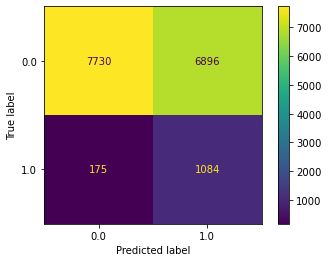

In [12]:
# Plot the confusion matrix
plot_confusion_matrix(lr_balance, X_test, Y_test)

#### Using One Hot Encoding to create a third model
Next, we will create a logistic regression model using the one hot encoded features and compare the performance.

In [13]:
lr_onehot = LogisticRegression(penalty='l2', C=1.0, class_weight='balanced', solver='liblinear' )
lr_onehot.fit(X_train_onehot,Y_train_onehot)
yhat = lr_onehot.predict(X_test_onehot)

acc = mt.accuracy_score(Y_test_onehot,yhat)
spe = mt.precision_score(Y_test_onehot,yhat)
auc = roc_auc_score(Y_test_onehot,yhat)
conf = mt.confusion_matrix(Y_test_onehot,yhat)
print("Accuracy: ", acc)
print("Precision: ", spe)
print("AUC: ", auc)
print("Confusion Matrix: \n",conf)

Accuracy:  0.5563109852061694
Precision:  0.13586614668511762
AUC:  0.694090284126313
Confusion Matrix: 
 [[7757 6869]
 [ 179 1080]]


With the additional features based on horse type and horse country, we increased our performance to 55.6248% at the cost of some added complexity.

#### Compare the three logistic regression models to predict a win

To compare the three models so far:
- Logistic Regression with basic features from the data set: 69.4756% AUC
- Logistic Regression with only odds predictors: 69.6173% AUC
- Logistic Regression with additional one-hot encoded features: 69.4056% AUC

Note the Logistic Regression model with only the odds predictors has the highest AUC score.

#### Create a model to predict if a horse will show

Lastly, we quickly created a logistic regression model using balanced classes and the horse country and type features, but predicted "show" instead of "win". So, this model predicts whether a horse will finish first, second, or third. Note, it achieved an accuracy of 59.3642% and an AUC of 67.7663%. The model is about 4% more accurate that predicting wins/losses but it has a lower AUC score.

In [14]:
lr_show = LogisticRegression(penalty='l2', C=1.0, class_weight='balanced', solver='liblinear' )
lr_show.fit(X_train_onehot_show,Y_train_onehot_show)
yhat = lr_show.predict(X_test_onehot_show)

acc = mt.accuracy_score(Y_test_onehot_show,yhat)
spe = mt.precision_score(Y_test_onehot_show,yhat)
auc = roc_auc_score(Y_test_onehot,yhat)
conf = mt.confusion_matrix(Y_test_onehot_show,yhat)

print("Accuracy: ", acc)
print("Precision: ", spe)
print("AUC: ", auc )
print("Confusion Matrix: \n",conf)

Accuracy:  0.5938306578533208
Precision:  0.3476295479603087
AUC:  0.6786284111976159
Confusion Matrix: 
 [[6280 5917]
 [ 535 3153]]


### SVM

Creating a Support Vector Machine (SVM) requires the data to be pre-processed into the appropriate format before the model can be trained. SVMs can handle both numerical and categorical predictors to classify a response. We are using this SVM to predict the won variable which describes whether the horse wone the race. To ensure the range of a predictors does not contribute to the influence of the variable over the response, we will scale the data first. Next, the data needs to be one-hot encoded. Attributes with many categories can cause the model training to be greatly slowed, so we will limit the categorical levels before encoding. With the data frame in the proper format, we need to balance the dataset to ensure the minority class is not ignored. We used down sampling of the losing horse class to balance the number of winning and losing horses. Finally, we will tune our model parameters and predict our test set. We used an 80/20 test/train split.

#### Scaling the data

In [15]:
url = "https://raw.githubusercontent.com/nedeinlein/Machine_Learning_I/main/runs_clean.csv"
runs_df = pd.read_csv(url, index_col=False)
runs_data = runs_df.drop(['Unnamed: 0','race_id','result','won','lengths_behind',
                          #'horse_id','horse_country','horse_type','horse_gear','trainer_id','jockey_id'
                          'position_sec1','position_sec2',
                          'position_sec3','behind_sec1','behind_sec2','behind_sec3','time1','time2',
                          'time3','finish_time'], axis=1)
runs_target = runs_df['won']

X_trainsvm,X_testsvm,Y_trainsvm,Y_testsvm = train_test_split(runs_data,runs_target,test_size=0.20,random_state=0)# Add a Place result feature


In [16]:
## Normalize the scales of variables (no need to scale y as that is the prediction)

#Remove categorical vars
cat_x_train = X_trainsvm[['horse_id','horse_country','horse_type','horse_gear','trainer_id','jockey_id']]
cat_x_test = X_testsvm[['horse_id','horse_country','horse_type','horse_gear','trainer_id','jockey_id']]
num_x_train = X_trainsvm.drop(['horse_id','horse_country','horse_type','horse_gear','trainer_id','jockey_id'],axis=1)
num_x_test = X_testsvm.drop(['horse_id','horse_country','horse_type','horse_gear','trainer_id','jockey_id'],axis=1)

#Very important to fit the scale to only the training data set... 
#and apply the transfromation to the test data set
scl_obj = StandardScaler()
scl_x_train = scl_obj.fit_transform(num_x_train)
scl_x_test = scl_obj.transform(num_x_test)

scl_x_train=pd.DataFrame(scl_x_train, columns=num_x_train.columns)
scl_x_test=pd.DataFrame(scl_x_test, columns=num_x_test.columns)

#Add categorical variables back in
scl_x_train.index = cat_x_train.index
scl_x_test.index = cat_x_test.index
scl_x_train = pd.concat([scl_x_train, cat_x_train],axis=1)
scl_x_test = pd.concat([scl_x_test, cat_x_test],axis=1)

scl_x_train.describe()

,horse_no,horse_age,horse_rating,declared_weight,actual_weight,draw,win_odds,place_odds,horse_id,trainer_id,jockey_id
count,6.353800e+04,6.353800e+04,6.353800e+04,6.353800e+04,6.353800e+04,6.353800e+04,6.353800e+04,6.353800e+04,63538.000000,63538.000000,63538.000000
mean,-2.725846e-18,6.377431e-17,2.029043e-16,-1.087930e-15,7.200289e-16,1.481742e-17,1.276115e-16,1.287298e-16,2203.900249,79.829016,85.929585
std,1.000008e+00,1.000008e+00,1.000008e+00,1.000008e+00,1.000008e+00,1.000008e+00,1.000008e+00,1.000008e+00,1275.321374,45.123485,54.310712
min,-1.568999e+00,-1.527638e+00,-4.343842e+00,-6.608647e+00,-3.133311e+00,-1.567262e+00,-9.238534e-01,-7.433377e-01,0.000000,0.000000,0.000000
25%,-7.707318e-01,-3.863104e-01,-8.556892e-02,-6.881142e-01,-7.514050e-01,-7.662460e-01,-7.011894e-01,-5.815941e-01,1085.000000,47.000000,39.000000
50%,2.753526e-02,-3.863104e-01,-8.556892e-02,-4.632208e-02,4.256376e-02,3.476977e-02,-4.585852e-01,-3.505319e-01,2209.000000,75.000000,76.000000
75%,8.258024e-01,-3.863104e-01,-8.556892e-02,6.596493e-01,8.365325e-01,8.357855e-01,3.057839e-01,8.848643e-02,3307.000000,118.000000,138.000000
max,1.890159e+00,7.602982e+00,6.557338e+00,4.237641e+00,1.630501e+00,1.903806e+00,2.333024e+00,1.080978e+01,4404.000000,175.000000,185.000000


Scaling the data allows us to keep any one category from unnecessarily affecting the outcome due to the range of its data. This is done by using the standard scaler function. This maps all continuous variables to a common scale while keeping the deviation from mean standard. This does not affect the data as the deviation remains constant and only the range is changed. 

#### Limiting the Categories

This is done to keep the number of one hot encoded categories we are about to create from getting out of hand and causing the model to be very resource intensive to run.

In [17]:
cat_lim_train=scl_x_train.copy()
cat_lim_test=scl_x_test.copy()

#Update Horse ID to horses who have raced over 60 times
horse_id_counts = cat_lim_train.horse_id.value_counts()
cat_lim_train.loc[~cat_lim_train.horse_id.isin(horse_id_counts.index[horse_id_counts.gt(60)]),'horse_id']='Other'
cat_lim_test.loc[~cat_lim_test.horse_id.isin(horse_id_counts.index[horse_id_counts.gt(60)]),'horse_id']='Other'
print('Horse ID')
print('original: ',len(scl_x_train.horse_id.unique()))
print('new: ',len(cat_lim_train.horse_id.unique()))
print(cat_lim_train.horse_id.unique(),"\n")

#Update Horse Country to countries that appear over 80 times
horse_country_counts = cat_lim_train.horse_country.value_counts()
cat_lim_train.loc[~cat_lim_train.horse_country.
                  isin(horse_country_counts.index[horse_country_counts.gt(80)]),'horse_country']='Other'
cat_lim_test.loc[~cat_lim_test.horse_country.
                 isin(horse_country_counts.index[horse_country_counts.gt(80)]),'horse_country']='Other'
print('Horse Country')
print('original: ',len(scl_x_train.horse_country.unique()))
print('new: ',len(cat_lim_train.horse_country.unique()))
print(cat_lim_train.horse_country.unique(),"\n")

#Update Horse Type to types that appear over 50 times
horse_type_counts = cat_lim_train.horse_type.value_counts()
cat_lim_train.loc[~cat_lim_train.horse_type.isin(horse_type_counts.index[horse_type_counts.gt(50)]),
                  'horse_type']='Other'
cat_lim_test.loc[~cat_lim_test.horse_type.isin(horse_type_counts.index[horse_type_counts.gt(50)]),
                 'horse_type']='Other'
print('Horse Type')
print('original: ',len(scl_x_train.horse_type.unique()))
print('new: ',len(cat_lim_train.horse_type.unique()))
print(cat_lim_train.horse_type.unique(),"\n")

#Update Horse Gear to gear combos that appear over 300 times
horse_gear_counts = cat_lim_train.horse_gear.value_counts()
cat_lim_train.loc[~cat_lim_train.horse_gear.isin(horse_gear_counts.index[horse_gear_counts.gt(300)]),
                  'horse_gear']='Other'
cat_lim_test.loc[~cat_lim_test.horse_gear.isin(horse_gear_counts.index[horse_gear_counts.gt(300)]),
                 'horse_gear']='Other'
print('Horse Gear')
print('original: ',len(scl_x_train.horse_gear.unique()))
print('new: ',len(cat_lim_train.horse_gear.unique()))
print(cat_lim_train.horse_gear.unique(),"\n")

#Update TrainerID to trainers that appear over 2500 times
trainer_id_counts = cat_lim_train.trainer_id.value_counts()
cat_lim_train.loc[~cat_lim_train.trainer_id.isin(trainer_id_counts.index[trainer_id_counts.gt(2500)]),
                  'trainer_id']='Other'
cat_lim_test.loc[~cat_lim_test.trainer_id.isin(trainer_id_counts.index[trainer_id_counts.gt(2500)]),
                 'trainer_id']='Other'
print('Trainer ID')
print('original: ',len(scl_x_train.trainer_id.unique()))
print('new: ',len(cat_lim_train.trainer_id.unique()))
print(cat_lim_train.trainer_id.unique(),"\n")

#Update JockeyID to jockeys that appear over 2000 times
jockey_id_counts = cat_lim_train.jockey_id.value_counts()
cat_lim_train.loc[~cat_lim_train.jockey_id.isin(jockey_id_counts.index[jockey_id_counts.gt(2000)]),
                  'jockey_id']='Other'
cat_lim_test.loc[~cat_lim_test.jockey_id.isin(jockey_id_counts.index[jockey_id_counts.gt(2000)]),
                 'jockey_id']='Other'
print('Jockey ID')
print('original: ',len(scl_x_train.jockey_id.unique()))
print('new: ',len(cat_lim_train.jockey_id.unique()))
print(cat_lim_train.jockey_id.unique())

Horse ID
original:  4308
new:  12
['Other' 107 2382 1849 4314 3887 779 4058 4041 493 3323 70] 

Horse Country
original:  16
new:  10
['NZ' 'USA' 'AUS' 'GB' 'IRE' 'FR' 'SAF' 'GER' 'Other' 'ARG'] 

Horse Type
original:  9
new:  7
['Gelding' 'Brown' 'Other' 'Colt' 'Horse' 'Mare' 'Rig'] 

Horse Gear
original:  735
new:  10
['--' 'TT/B' 'Other' 'B' 'CP' 'TT/H' 'H' 'TT' 'XB' 'SR'] 

Trainer ID
original:  155
new:  13
[97 118 7 80 69 'Other' 137 98 75 47 55 164 138] 

Jockey ID
original:  178
new:  13
[76 175 'Other' 162 50 40 34 63 2 138 64 18 149]


Many of the categorical variables in the dataset have hundreds or thousands of categories. To simplify the classes, we will use a minimum instance limit for each categorical variable to determine which classes to keep (instance limit in code notes above each section). Any class not meeting the instance limit, will be classified as 'Other'. This generalization of the smaller classes will be done using the training data set and then the results will be applied to the test data set. In the above output, each categorical variable is shown with the original number of categories and the new number of categories after generalization. A list of the new unique categories is listed at the end of each section.

### One Hot Encode
For the SVM to be able to interpret categorical data, it must be one-hot encoded. This means that each class in each categorical variable will become a column. By limiting the categorical variable classes above, we ensured the data frame will not overly expand. After creating the dummy variables and adding them to our existing test and training sets, we must drop the original categorical variables and one class from each categorical variable. The 'Other' class was dropped from each categorical variable. The below output shows the shape of the training and test sets before and after performing the one-hot encoding process. The data sets do not change the number of instances but they expanded from 14 to 67 columns.

In [18]:
#Create Dummies for training and test
dummies_train = pd.get_dummies(
    cat_lim_train[['horse_id','horse_country','horse_type','horse_gear','trainer_id','jockey_id']])
dummies_test = pd.get_dummies(
    cat_lim_test[['horse_id','horse_country','horse_type','horse_gear','trainer_id','jockey_id']])

#Add dummies back to original data frames
final_train = pd.concat([cat_lim_train, dummies_train],axis=1)
final_test = pd.concat([cat_lim_test, dummies_test],axis=1)

#Drop original variable and one class for each variable (the dropped class is 'Other')
final_train = final_train.drop(['horse_id','horse_country','horse_type','horse_gear','trainer_id','jockey_id',
                            'horse_id_Other','horse_country_Other','horse_type_Other','horse_gear_Other',
                            'trainer_id_Other','jockey_id_Other'], axis=1)
final_test = final_test.drop(['horse_id','horse_country','horse_type','horse_gear','trainer_id','jockey_id',
                            'horse_id_Other','horse_country_Other','horse_type_Other','horse_gear_Other',
                            'trainer_id_Other','jockey_id_Other'], axis=1)

print('Original Training Set Shape Before Dummies:\n',cat_lim_train.shape)
print('Original Test Set Shape Before Dummies:\n',cat_lim_test.shape)
print('New Training Set Shape After Dummies:\n',final_train.shape)
print('New Test Set Shape After Dummies:\n',final_test.shape)

Original Training Set Shape Before Dummies:
 (63538, 14)
Original Test Set Shape Before Dummies:
 (15885, 14)
New Training Set Shape After Dummies:
 (63538, 67)
New Test Set Shape After Dummies:
 (15885, 67)


### SVM Models
Below are the test SVM models that were run to find the optimum C value. It is important to note that because our dataset is not balanced (equal number of instances of our binary predicted category), we had to insert into the SVM code that we wanted the data balanced. This keeps the model from defaulting to a prediction of negative or positive just because it will be accurate a large percentage of the time.

accuracy: 0.603399433427762
auc: 0.698609801579591


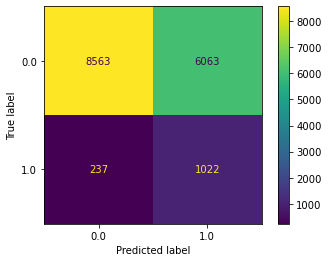

In [19]:
# train the model just as before
svm_clf = SVC(C=5, kernel='rbf', gamma='auto',class_weight = 'balanced') # get object
svm_clf.fit(final_train, Y_trainsvm)  # train object

y_hat = svm_clf.predict(final_test) # get test set precitions

acc = mt.accuracy_score(Y_testsvm,y_hat)
conf = mt.confusion_matrix(Y_testsvm,y_hat)
auc=roc_auc_score(Y_testsvm,y_hat)
print('accuracy:', acc )
print('auc:',auc)
disp=ConfusionMatrixDisplay(confusion_matrix=conf,  display_labels=svm_clf.classes_)
disp.plot()

accuracy: 0.6209631728045326
auc: 0.6987107837924933


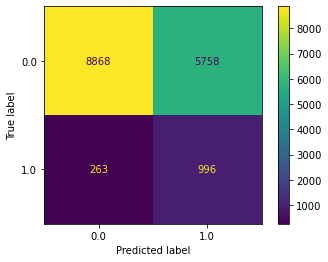

In [20]:
# train the model just as before
svm_clf = SVC(C=10, kernel='rbf', gamma='auto',class_weight = 'balanced') # get object
svm_clf.fit(final_train, Y_trainsvm)  # train object

y_hat = svm_clf.predict(final_test) # get test set precitions

acc = mt.accuracy_score(Y_testsvm,y_hat)
conf = mt.confusion_matrix(Y_testsvm,y_hat)
auc=roc_auc_score(Y_testsvm,y_hat)
print('accuracy:', acc )
print('auc:',auc)
disp=ConfusionMatrixDisplay(confusion_matrix=conf,  display_labels=svm_clf.classes_)
disp.plot()

accuracy: 0.6382121498268807
auc: 0.7000926570861274


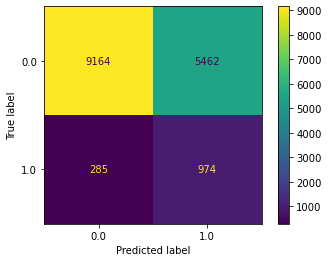

In [21]:
# train the model just as before
svm_clf = SVC(C=20, kernel='rbf', gamma='auto',class_weight = 'balanced') # get object
svm_clf.fit(final_train, Y_trainsvm)  # train object

y_hat = svm_clf.predict(final_test) # get test set precitions

acc = mt.accuracy_score(Y_testsvm,y_hat)
conf = mt.confusion_matrix(Y_testsvm,y_hat)
auc=roc_auc_score(Y_testsvm,y_hat)
print('accuracy:', acc )
print('auc:',auc)
disp=ConfusionMatrixDisplay(confusion_matrix=conf,  display_labels=svm_clf.classes_)
disp.plot()

accuracy: 0.6450110166824048
auc: 0.6979774340731961


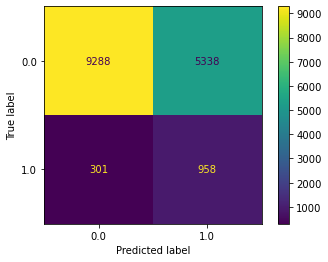

In [22]:
# train the model just as before
svm_clf = SVC(C=30, kernel='rbf', gamma='auto',class_weight = 'balanced') # get object
svm_clf.fit(final_train, Y_trainsvm)  # train object

y_hat = svm_clf.predict(final_test) # get test set precitions

acc = mt.accuracy_score(Y_testsvm,y_hat)
conf = mt.confusion_matrix(Y_testsvm,y_hat)
auc=roc_auc_score(Y_testsvm,y_hat)
print('accuracy:', acc )
print('auc:',auc)
disp=ConfusionMatrixDisplay(confusion_matrix=conf,  display_labels=svm_clf.classes_)
disp.plot()

#### Introducing PCA to the SVM.
##### We wanted to see if PCA would allow us to create a simpler model while maintaining or beating the results of our previous SVM models.

In [23]:
from sklearn.preprocessing import MinMaxScaler
from sklearn.decomposition import PCA
scaler = MinMaxScaler()
pca = PCA(n_components = 0.90)

pca_train = final_train[['horse_age','horse_rating','declared_weight','actual_weight','draw','win_odds','place_odds']]
pca_train_cat = final_train.drop(['horse_age','horse_rating','declared_weight','actual_weight','draw','win_odds','place_odds'],axis = 1)
x_pcatrain = pca.fit(pca_train).transform(pca_train)
train_rescaled = scaler.fit_transform(x_pcatrain)
x_pcatrain_scaled = pd.DataFrame(train_rescaled)


pca_test = final_test[['horse_age','horse_rating','declared_weight','actual_weight','draw','win_odds','place_odds']]
pca_test_cat = final_test.drop(['horse_age','horse_rating','declared_weight','actual_weight','draw','win_odds','place_odds'],axis = 1)
x_pcatest = pca.fit(pca_test).transform(pca_test)
test_rescaled = scaler.fit_transform(x_pcatest)
x_pcatest_scaled = pd.DataFrame(x_pcatest)

x_pcatrain_scaled.index=pca_train_cat.index
x_pcatest_scaled.index=pca_test_cat.index
x_pcatrain_scaled = pd.concat([x_pcatrain_scaled,pca_train_cat],axis = 1)
x_pcatest_scaled = pd.concat([x_pcatest_scaled,pca_test_cat],axis = 1)
print(x_pcatrain_scaled.head())

              0         1         2         3         4         5  horse_no  \
62425  0.097036  0.617278  0.423656  0.563266  0.384596  0.463863 -1.568999   
39062  0.333968  0.248757  0.460645  0.304355  0.237899  0.485294  0.293624   
59609  0.155046  0.430443  0.206038  0.398017  0.583271  0.392250  0.559713   
21589  0.133814  0.311395  0.355892  0.302755  0.441354  0.390363  1.091891   
70137  0.148794  0.068225  0.451088  0.453993  0.557737  0.629332  1.624069   

       horse_id_70  horse_id_107  horse_id_493  ...  jockey_id_34  \
62425            0             0             0  ...             0   
39062            0             0             0  ...             0   
59609            0             0             0  ...             0   
21589            0             0             0  ...             0   
70137            0             0             0  ...             0   

       jockey_id_40  jockey_id_50  jockey_id_63  jockey_id_64  jockey_id_76  \
62425             0            

The above code takes the continuous variables and reduces their number from 7 down to 2 while maintaining 90% of the variability in the data. We then used this to run 3 models similar to the most successful above to judge efficiency and accuracy.

accuracy: 0.33471828769279194
auc: 0.6267480458217585


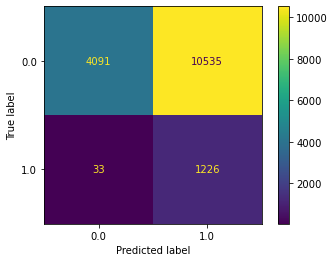

In [24]:
# train the model
svm_clf = SVC(C=10, kernel='rbf', gamma='auto',class_weight = 'balanced') # get object
svm_clf.fit(x_pcatrain_scaled,Y_trainsvm)  # train object

y_hat = svm_clf.predict(x_pcatest_scaled) # get test set precitions

acc = mt.accuracy_score(Y_testsvm,y_hat)
conf = mt.confusion_matrix(Y_testsvm,y_hat)
auc=roc_auc_score(Y_testsvm,y_hat)
print('accuracy:', acc )
print('auc:',auc)
disp=ConfusionMatrixDisplay(confusion_matrix=conf,  display_labels=svm_clf.classes_)
disp.plot()

accuracy: 0.3327038086244885
auc: 0.625291148636151


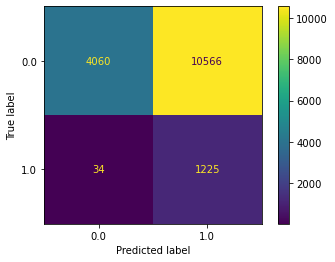

In [25]:
# train the model
svm_clf = SVC(C=20, kernel='rbf', gamma='auto',class_weight = 'balanced') # get object
svm_clf.fit(x_pcatrain_scaled,Y_trainsvm)  # train object

y_hat = svm_clf.predict(x_pcatest_scaled) # get test set precitions

acc = mt.accuracy_score(Y_testsvm,y_hat)
conf = mt.confusion_matrix(Y_testsvm,y_hat)
auc=roc_auc_score(Y_testsvm,y_hat)
print('accuracy:', acc )
print('auc:',auc)
disp=ConfusionMatrixDisplay(confusion_matrix=conf,  display_labels=svm_clf.classes_)
disp.plot()

accuracy: 0.3304375196726472
auc: 0.6244234184458526


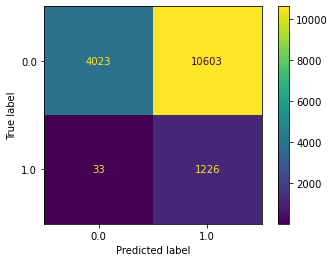

In [26]:
svm_clf = SVC(C=30, kernel='rbf', gamma='auto',class_weight = 'balanced') # get object
svm_clf.fit(x_pcatrain_scaled,Y_trainsvm)  # train object

y_hat = svm_clf.predict(x_pcatest_scaled) # get test set precitions

acc = mt.accuracy_score(Y_testsvm,y_hat)
conf = mt.confusion_matrix(Y_testsvm,y_hat)
auc=roc_auc_score(Y_testsvm,y_hat)
print('accuracy:', acc )
print('auc:',auc)
disp=ConfusionMatrixDisplay(confusion_matrix=conf,  display_labels=svm_clf.classes_)
disp.plot()

After running the various SVM models with PCA, it was determined that none of them could create a model as good as the one we created without PCA. As a result we chose to go with the model of C = 20, for our best SVM model to then compare against the logistic regression model. 

## Section 2: Model Advantages

When looking at these two types of models we determined that AUC should be the main judge of model performance as it looks for a middle ground between sensitivity, specificity, and accuracy. This allows us to keep a much more balanced model that seeks the middle ground of these three instead of working on simply accuracy. Since we know ~90% accuracy can be reached simply by predicting all horses will lose, which is not reasonable, we need to have the model at least attempting to determine positive results. Our best logistic regression model for predicting wins came in with an AUC of .694. This is not an ideal high but it does show that the model should be more effective than our minimum request of random chance (50/50). 
After testing multiple SVM models, we found a C value of 20, with no PCA created our optimum model. This has the best AUC and accuracy with .7 and .638 respectively. This was also our best performing model over all.
One benefit of the logistic regression models should be mentioned, and that is that they were much less resource intensive to run. The normal run time for the full logistic regression model was a minute max. The SVM models typically took up to 7 minutes to run the full model. While there is a benefit to an AUC/ accuracy gain here. It is not a model that we would probably want to employ to do real time without adding computing power. But for predictions where time is not an issue, this seems to work best.

Logistic Regression has another significant advantage over Support Vectors due to its easy interpretability. A model is interpretable if the user can understand how a model reached it's conclusion. In Logistic Regression we can look at the weights of each predictor feature, as we did in the Section Interpret Feature Weights. 
Using the sklearn implementation of Logistic Regression we were easily able to pull the feature weights via coefficient variable. This gives us a high level of insight into the model and how it reaches its classification results


## Section 3: Interpret Feature Importance

### Logistic Regression Model Weight Interpretation

Now that we have determined a class balanced logistic regression model is preferred, we wanted to evaluate how much each predictor contributed to the model. We find the coefficient values for weight and then plot them to visually compare.

In [27]:
# Look at the weights
# Source: github/jakemdrew/DataMiningNotebook 4

weights = lr_balance.coef_.T
variable_names = X_train.columns
for coef, name in zip(weights,variable_names):
    print(name, 'has weight of', coef[0])

horse_no has weight of -0.002237582389797706
horse_age has weight of 0.004382533054706093
horse_rating has weight of 0.0007784070802225644
declared_weight has weight of 0.0008365774594354245
actual_weight has weight of 0.000344143319115088
draw has weight of -0.0043668684501058964
win_odds has weight of -0.05976259672683009
place_odds has weight of -0.012987965241014102


#### Logistic Regression Model Feature Weights

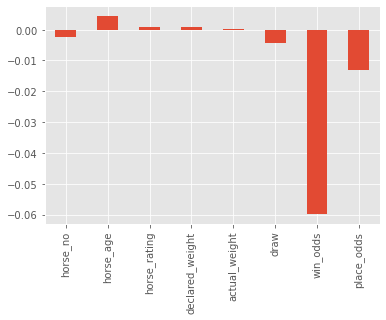

In [28]:
# Plot the weights to compare them
# Source: github/jakemdrew/DataMiningNotebook 4

plt.style.use('ggplot')

weights = pd.Series(lr_balance.coef_[0],index=X_train.columns)
weights.plot(kind='bar')
plt.show()

As can be seen above, odds to win and odds to show are by far the most important predictors. This intuitively makes sense. Let's re-run the logistic regression model again using only those two predictors and compare the performance to the previous model.

In [29]:
# Use Logistic Regression to predict win/loss - Class Balance
X_train_lite = X_train[['win_odds', 'place_odds']]
X_test_lite = X_test[['win_odds', 'place_odds']]


lr_lite = LogisticRegression(penalty='l2', C=1.0, class_weight='balanced', solver='liblinear' )
lr_lite.fit(X_train_lite,Y_train)
yhat = lr_lite.predict(X_test_lite)

acc = mt.accuracy_score(Y_test,yhat)
spe = mt.precision_score(Y_test,yhat)
auc = roc_auc_score(Y_test_onehot,yhat)
conf = mt.confusion_matrix(Y_test,yhat)
print("Accuracy: ", acc)
print("Precision: ", spe)
print("AUC: ", auc)
print("Confusion Matrix: \n",conf)

weights = lr_lite.coef_.T
variable_names = X_train.columns
for coef, name in zip(weights,variable_names):
    print(name, 'has weight of', coef[0])

Accuracy:  0.5548001259049418
Precision:  0.13618725747903368
AUC:  0.6961734665339135
Confusion Matrix: 
 [[7725 6901]
 [ 171 1088]]
horse_no has weight of -0.060321797598908315
horse_age has weight of -0.013115988277507097


For the previous model with many predictors, we achieved an accuracy of 55.4863%. For the model where we only used win odds and place odds, we achieved an almost identical accuracy of 55.48001% with a simpler model.

Finally, we will look at feature importance for the model with that includes horse_type and horse_country.


In [42]:
# We will not visually plot these weights since the plot becomes too cluttered to read
weights = lr_onehot.coef_.T
variable_names = X_train_onehot.columns
for coef, name in zip(weights,variable_names):
    print(name, 'has weight of', coef[0])

horse_no has weight of -0.0024870505805077545
horse_age has weight of 0.008237926772741964
horse_rating has weight of 0.0010698652852967603
declared_weight has weight of 0.000735334178154562
actual_weight has weight of 0.00019055572074231134
draw has weight of -0.004431553520961559
win_odds has weight of -0.05991073071369041
place_odds has weight of -0.01236065489343102
horse_country_ARG has weight of -0.24823770311350976
horse_country_AUS has weight of 0.12429964630440625
horse_country_BRZ has weight of 0.5395881537384372
horse_country_CAN has weight of -0.23354805171485807
horse_country_FR has weight of 0.10125543421035903
horse_country_GB has weight of 0.14864822460669105
horse_country_GER has weight of -0.42735644540589696
horse_country_GR has weight of -1.3706364564798625
horse_country_IRE has weight of 0.04888636925259086
horse_country_ITY has weight of -0.9590374344115735
horse_country_JPN has weight of 0.2972277461894717
horse_country_NZ has weight of 0.14446831995520779
horse_

When tuning our parameters for the logistic regression function, we opted to use the 'L2' penalty. Also know as ridge regression, we can use this penalty to tune data that suffers from multicollinearity. However, the disadvantage of using the 'l2' penalty is that all of our predictors will remain in our final fit, unlike using a lasso or elastic net method which pushes insignificant coefficients to zero. 

The weights of our features are important in understanding how important a single feature is when predicting whether a particular horse will win or not win a race. Since our response is on a probability scale between 0 and 1 , we have to interpret these weights differently than we would with linear regression. For example, when interpreting the weight of the horse_country_GR categorical feature, we can say that the odds for a win are 1.38 lower if the horse was from Greece than the reference category for country if all factors remained equivalent. For a numerical feature like win_odds, an increase by one in win_odds, decreases the odds of winning by a factor of .05 if all other factors are held equivalent.

Based off the weights above, there are particular features of importance. Betting on a horse from Zimbabwe/South Africa increases the odds of that particular horse winning the race by a factor of 1.36. This makes sense as horse racing in Zimbabwe and South Africa is very popular among the rich and famous people there. Not only that, but three of the most famous horse races are in South Africa (https://www.sa-venues.com/activities/horse-racing.php).

When looking at the encoded horse type columns, we can see that betting on a colt or a rig will increase your odds more than any other type of horse. These two horses are popular among competitors as they are male horses usually below the age of four.


## Section 4: Interpret Support Vectors

When we began to look at the main factors that contributed to our support vector models, we found that expressing them graphically was the easiest way to get a handle on the data.

In [ ]:
#Function referenced from https://stackoverflow.com/questions/41592661/determining-the-most-contributing-features-for-svm-classifier-in-sklearn
svm_clf = SVC(C=20, kernel='linear', gamma='auto',class_weight = 'balanced') # get object
svm_clf.fit(final_train, Y_trainsvm)  # train object

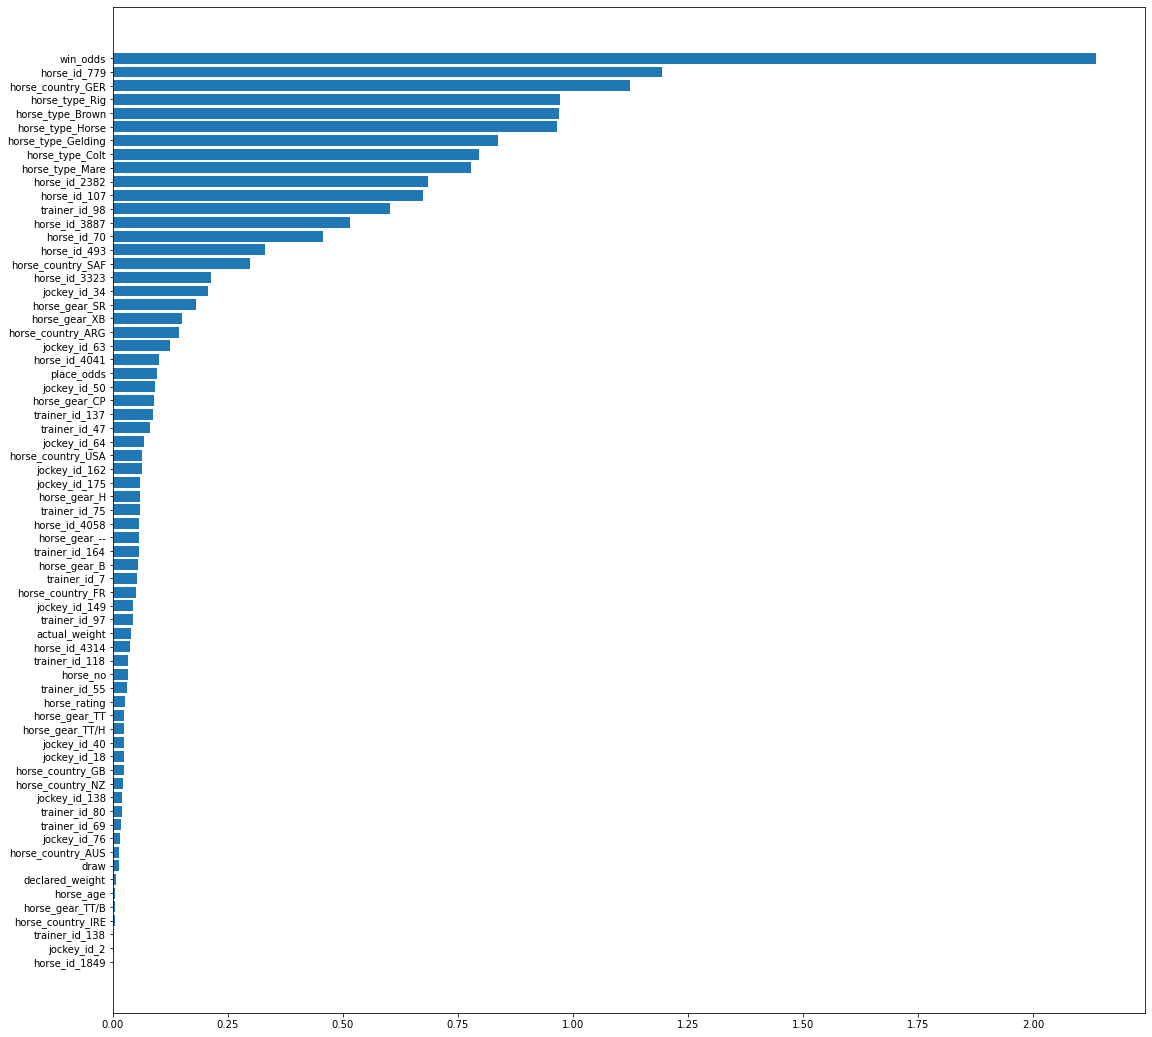

In [14]:
#Function referenced from https://stackoverflow.com/questions/41592661/determining-the-most-contributing-features-for-svm-classifier-in-sklearn
def f_importances(coef, names):
    imp = np.absolute(coef)
    imp,names = zip(*sorted(zip(imp,names)))
    fig = matplotlib.pyplot.gcf()
    fig.set_size_inches(18.5, 18.5, forward=True)
    plt.barh(range(len(names)), imp, align='center')
    plt.yticks(range(len(names)), names)
    plt.show()

features=balanced_final_train.columns.to_list
f_importances(svm_clf.coef_[0], balanced_final_train.columns)

When looking at this data we can see that by far, win_odds contributed the most to predicting a win. This makes sense as win_odds are based on statistical data and expert knowledge to predict the winner of any given race. The next group of important variables seemed to come in two groups, the first being horse_id, specific horses that just one a large number of competitions, and horse_type. We would expect some collinearity between these two groups but, both are rather crucial in predicting a winner in any given competition. The fact that these two were so dominant in prediction weight in these models in interesting as there are a number of other variables one would normally assume to have more impact. 

### Overall Conclusions

Overall, we would assume that given large resources or lack of a time parameter, that the SVM model should be used over logistic regression for this particular data set. It would be interesting to note if by pruning some of the one hot encode values, if we could further increase the accuracy and efficiencies of both models without a loss of prediction ability (variance or bias).